*Note: 
- This notebook borrows from the following sources:*
    - Victor Lavrenko's PCA series: https://www.youtube.com/playlist?list=PLBv09BD7ez_5_yapAg86Od6JeeypkS4YM
- The formatting of this notebook gets a bit uncooperative when viewed on GitHub. Suggest opening it in Jupyter

##### Before we can get into PCA, we should understand it's motivation.
### The Curse of Dimensionality

Consider the following 3-class data:

In [1]:
import sklearn
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [2]:
iris = load_iris()
X = iris.data
y = iris.target
min_x = np.min(X[:,0])
max_x = np.max(X[:,0])
setosa = np.argwhere(y==0)
versicolor = np.argwhere(y==1)
virginica = np.argwhere(y==2)
colors = ['red', 'green', 'blue']
shapes = ['circle', 'square', 'triangle']
zeros = np.zeros_like(X[:,0])

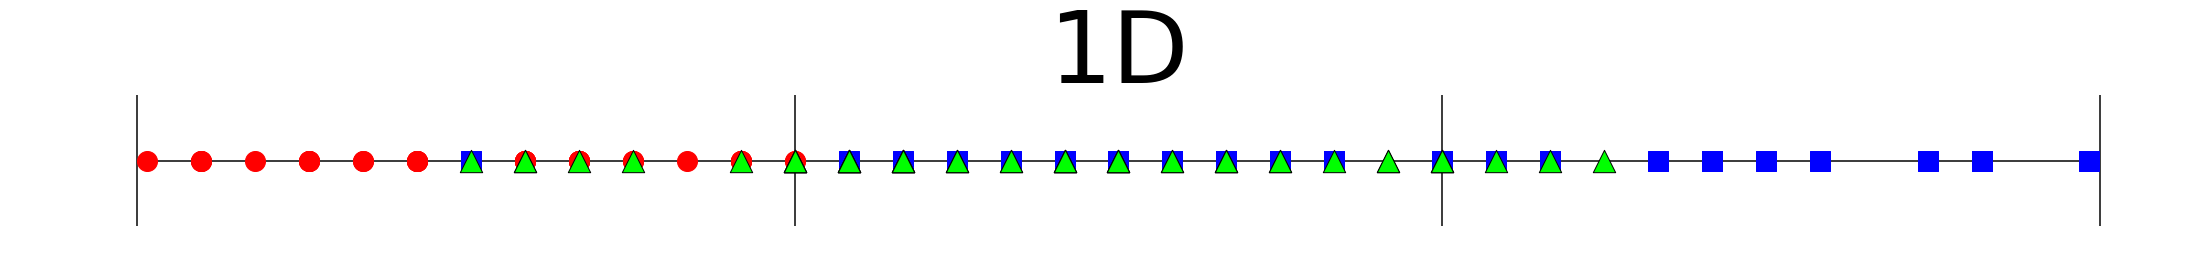

In [3]:
plt.axes([min_x, max_x, 5, .5])
plt.scatter(X[setosa, 0], zeros[setosa], marker='o', c='r', s=400, zorder=2, label='supressWarning')
plt.scatter(X[versicolor, 0], zeros[versicolor], marker='^', c='lime', s=500, zorder=3, edgecolors='black')
plt.scatter(X[virginica, 0], zeros[virginica], marker='s', c='blue', s=400, zorder=2)
plt.hlines(0, min_x, max_x, zorder = 1)
plt.vlines([min_x-.02, min_x + ((max_x - min_x)/3), min_x + ((max_x - min_x)/3*2), max_x+.02], -1, 1, zorder = 1)
plt.axis('off')
plt.title("1D", size=100)
plt.show()

In 1D, if we split our data into thirds, we naturally get 3 sections. Each section is densely populated by data points - any new datapoint would be close to existing datapoints. Thus, we get a pretty good idea of where our datapoint 'sits' in the context of existing data.

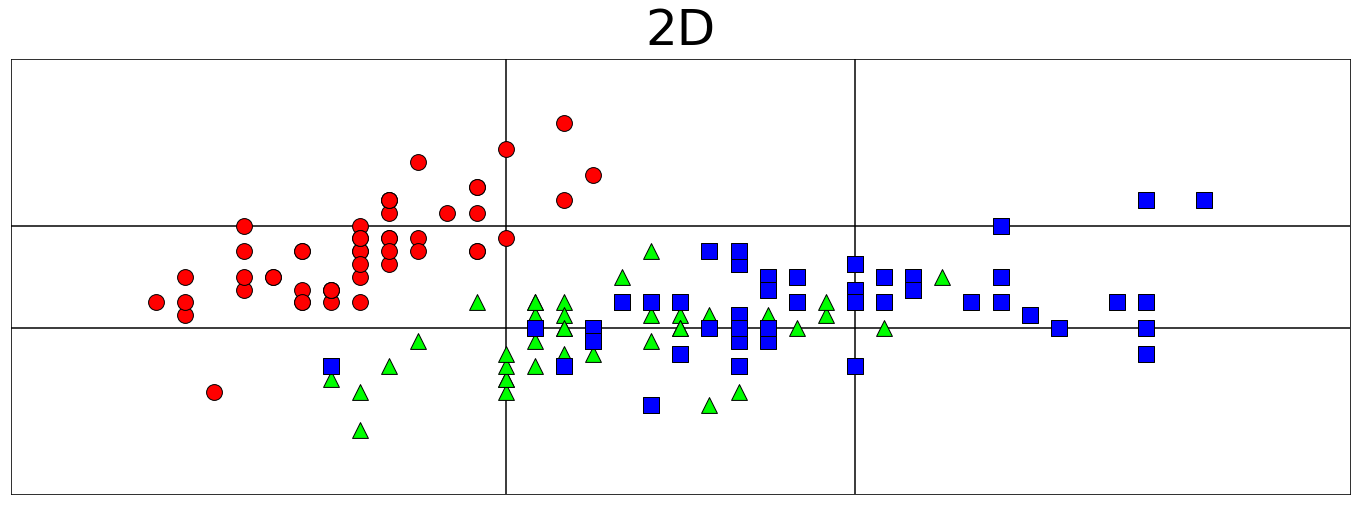

In [4]:
y_min = np.min(X[:,1])
y_max = np.max(X[:,1])
y_range = y_max - y_min
fig, ax = plt.subplots(figsize=(24,8))
ax.axes.set_xticks([])
ax.axes.set_yticks([])
ax.set_xlim(min_x-.5, max_x+.5)
ax.set_ylim(y_min-.5, y_max+.5)
ax.scatter(X[setosa, 0], X[setosa, 1], marker='o', c='r', s=250, zorder=2, label='supressWarning', edgecolors='black')
ax.scatter(X[versicolor, 0], X[versicolor, 1], marker='^', c='lime', s=250, zorder=2, edgecolors='black')
ax.scatter(X[virginica, 0], X[virginica, 1], marker='s', c='blue', s=250, zorder=2, edgecolors='black')
plt.title("2D", size=50, y = 1.02)
ax.hlines((y_min + y_range/3), 3, 9, zorder = 1)
ax.hlines((y_min + y_range/3*2), 3, 9, zorder = 1)
ax.vlines(min_x + (max_x - min_x)/3, 0, 9, zorder = 1)
ax.vlines(min_x + (max_x - min_x)/3*2, 0, 9, zorder = 1)
plt.show()

In two dimensions, if we split our data into thirds, we now have 9 sections to fill, with some of them starting to get sparsely filled.

As we increase dimension, we start to get more and more sparse sections. This means that when we get a new datapoint, it could be pretty far from other existing points, and thus we'd have a hard time generalizing to the new data. 

Also, we can start to exponentially increase computation cost, having to deal with computing values in many more dimensions.

    
>***The Curse of Dimensionality makes it hard to generalize learning algorithms when working with high-dimension data***

### Dimensionality Reduction
Notice that we can pretty confidently guess that no new data would appear in the far upper-left, like the added yellow point, for example:

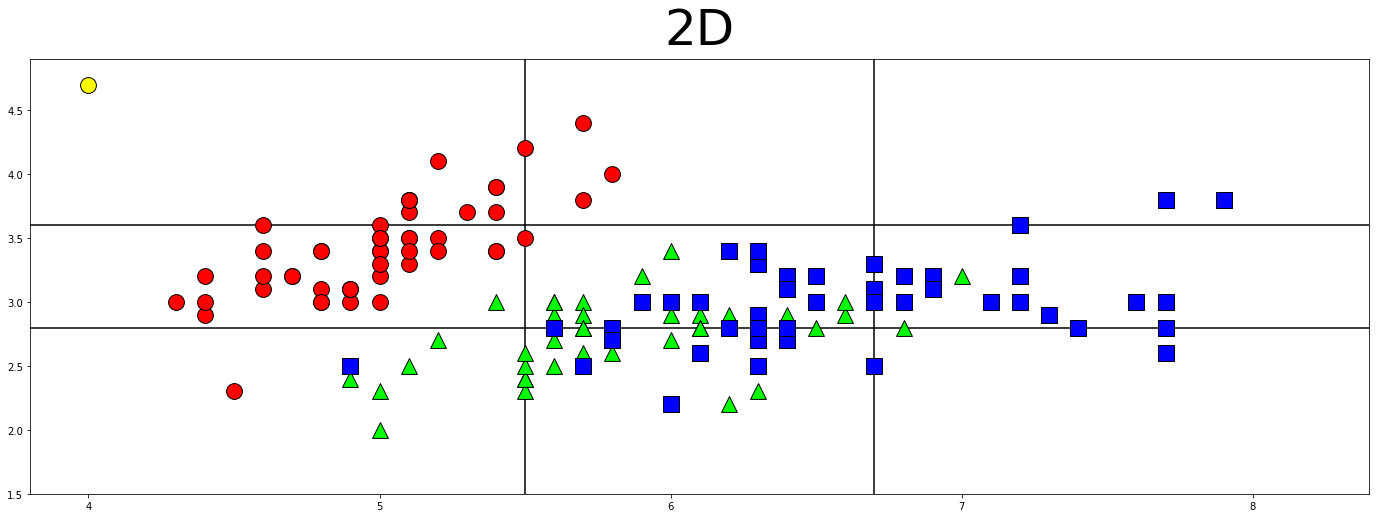

In [5]:
y_min = np.min(X[:,1])
y_max = np.max(X[:,1])
y_range = y_max - y_min
fig, ax = plt.subplots(figsize=(24,8))
ax.set_xlim(min_x-.5, max_x+.5)
ax.set_ylim(y_min-.5, y_max+.5)
ax.scatter(X[setosa, 0], X[setosa, 1], marker='o', c='r', s=250, zorder=2, label='supressWarning', edgecolors='black')
ax.scatter(X[versicolor, 0], X[versicolor, 1], marker='^', c='lime', s=250, zorder=2, edgecolors='black')
ax.scatter(X[virginica, 0], X[virginica, 1], marker='s', c='blue', s=250, zorder=2, edgecolors='black')
ax.scatter(4, 4.7, edgecolors='black', c='yellow', s=250)
plt.title("2D", size=50, y = 1.02)
ax.hlines((y_min + y_range/3), 3, 9, zorder = 1)
ax.hlines((y_min + y_range/3*2), 3, 9, zorder = 1)
ax.vlines(min_x + (max_x - min_x)/3, 0, 9, zorder = 1)
ax.vlines(min_x + (max_x - min_x)/3*2, 0, 9, zorder = 1)
plt.show()

Why can we feel comfortable making this assertion? It's because intuitively, we can tell that each of these classes falls pretty well along a 'line-of-best-fit', and none of these lines go anywhere near the top left. We can take advantage of this fact, noting that best-fit lines are 1D structures, 'hidden' here within 2D-space.

Take the blue class, for example. We could take blue datapoint and turn its (x,y) coordinates into one (z) coordinate, where this new coordinate represents how far along the 'line-of-best-fit' the datapoint sits. If deviation from this line is due to noise, or otherwise not useful/significant, we just reduced the dimensionality of our data while keeping all the important information. Now, we are less affected by the Curse of Dimensionality.

    
>***Dimensionality Reduction combats the Curse of Dimensionality by representing the important information in fewer dimensions***

### Aside: What Naive Bayes does, graphically

Naive Bayes' assumption of independence can be visualized as doing the following (as it counts along the x-axis, here):

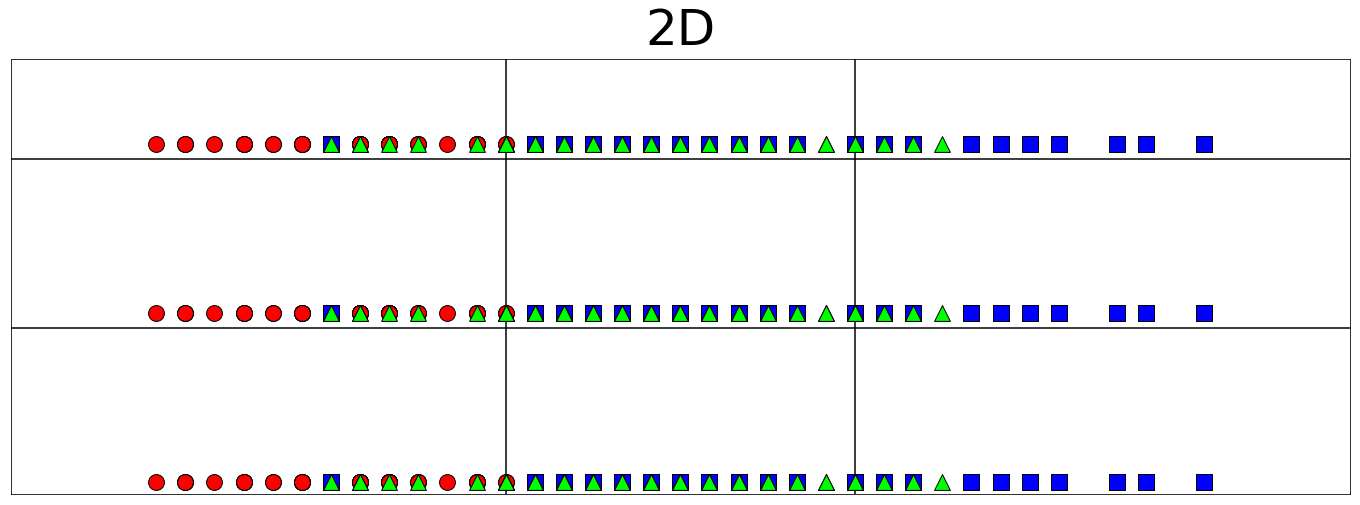

In [6]:
fig, ax = plt.subplots(figsize=(24,8))
ax.axes.set_xticks([])
ax.axes.set_yticks([])
flat = np.full(X.shape[0], y_min)
ax.set_xlim(min_x-.5, max_x+.5)
ax.set_ylim(y_min-.06, 4)
# Note to self: can we reduce lines of code by referring to shape & color vectors? One ax.scatter() per 'height'?
ax.scatter(X[setosa, 0], flat[setosa], marker='o', c='r', s=250, zorder=2, label='supressWarning', edgecolors='black')
ax.scatter(X[versicolor, 0], flat[versicolor], marker='^', c='lime', s=250, zorder=3, edgecolors='black')
ax.scatter(X[virginica, 0], flat[virginica], marker='s', c='blue', s=250, zorder=2, edgecolors='black')
ax.scatter(X[setosa, 0], flat[setosa]+y_range/3, marker='o', c='r', s=250, zorder=2, edgecolors='black')
ax.scatter(X[versicolor, 0], flat[versicolor]+y_range/3, marker='^', c='lime', s=250, zorder=3, edgecolors='black')
ax.scatter(X[virginica, 0], flat[virginica]+y_range/3, marker='s', c='blue', s=250, zorder=2, edgecolors='black')
ax.scatter(X[setosa, 0], flat[setosa]+y_range/3*2, marker='o', c='r', s=250, zorder=2, edgecolors='black')
ax.scatter(X[versicolor, 0], flat[versicolor]+y_range/3*2, marker='^', c='lime', s=250, zorder=3, edgecolors='black')
ax.scatter(X[virginica, 0], flat[virginica]+y_range/3*2, marker='s', c='blue', s=250, zorder=2, edgecolors='black')
plt.title("2D", size=50, y = 1.02)
ax.hlines((y_min + y_range/3)-.07, 3, 9, zorder = 1)
ax.hlines((y_min + y_range/3*2)-.07, 3, 9, zorder = 1)
ax.vlines(min_x + (max_x - min_x)/3, 0, 9, zorder = 1)
ax.vlines(min_x + (max_x - min_x)/3*2, 0, 9, zorder = 1)
plt.show()

Making assumptions such as these are one way to combat the Curse of Dimensionality. 

If we don't want to make assumptions about the data, as Naive Bayes does, we turn to dimensionality reduction.

### Recap: What do we mean by dimension reduction?
We are looking for ways to represent our data in fewer dimensions whilst *retaining as much of the structure as possible*. If we aren't yet sure what we mean by structure for a given example, oftentimes variance is a good measure - we will see why later.


##### How can we implement dimension reduction?
Two main methods exist:
- Feature Selection
    - Keep 'good' features
    - Throw others away
- Feature Extraction
    - Makes use of all existing features
    - Combine them in some way to make a smaller number of new features
    - Oftentimes these new features tell us something about the manifolds underlying the data
        - Once, I analyzed amino acid positions within a certain protein
        - A few particular dimensions 'combined' under PCA, highlighting an important, discriminative fold in the protein's structure.

    
>***PCA is a feature extraction method which produces linear combinations of existing features***

##### What does PCA actually give us?

PCA provides a new set basis vectors (basically new axes), called 'components'. Projecting our existing data onto this new basis, we get new features/attributes/columns. We'll get fewer of these than what we started with, but we'll still do a pretty good job at maintaining all the information we started out with. Only in the worst-case-scenario of perfectly uncorrelated data (like a perfect circle) can we do no better than the original set of attributes.

##### What do the components represent?

The first component lies along the direction of greatest variance in the data. 

Sucessive components, all perpendicular to one another, sucessively describe the 'next-greatest' directions of variance. <br> - Personally, I like to think of new components as describing the direction of greatest 'so-far-unaccounted-for' variance.

For example, in the graph below, the red line indicates the first principal component, and the blue line the second.

In [ ]:
from sklearn.decomposition import PCA

# Make a noisy straight line
base_data = np.arange(1,56,1)
example = np.zeros([55,2])
example[:,0] = base_data + 4*np.random.randn(55)
example[:, 1] = base_data + 4*np.random.randn(55)

<a id='PCA'>

Resulting principal components (each row is a component, the columns are the coordinates:

[[-0.67318377 -0.73947523]
 [ 0.73947523 -0.67318377]]


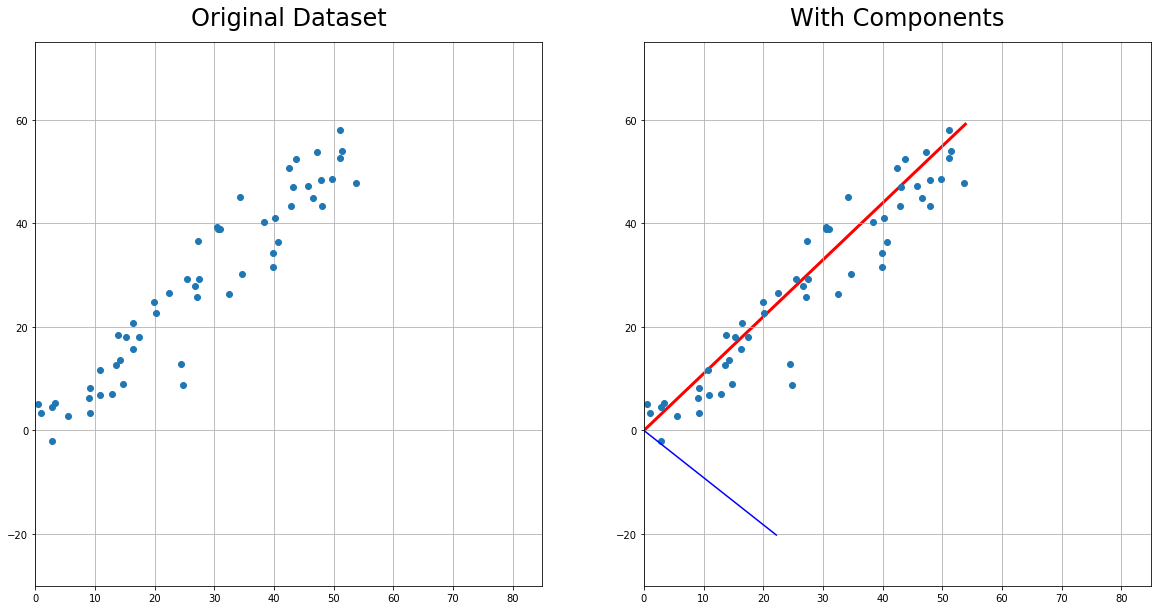

In [198]:
# Plot the line
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_xlim(0, 85)
ax1.set_ylim(-30, 75)
ax1.scatter(example[:,0], example[:,1], zorder=2)
ax1.grid()
ax1.set_title("Original Dataset", fontsize=24, y=1.02)

# Do quick PCA
pca = PCA(n_components=2)
res = pca.fit_transform(example)
print("Resulting principal components (each row is a component, the columns are the coordinates:\n")
print(pca.components_)

#Plot
ax2.set_xlim(0, 85)
ax2.set_ylim(-30, 75)
ax2.scatter(example[:,0], example[:,1], zorder=2)
ax2.plot([0, -80*pca.components_[0][0]], [0, -80*pca.components_[0][1]], c='r', lw = 3, zorder=1)
ax2.plot([0, 30*pca.components_[1][0]], [0, 30*pca.components_[1][1]], c='b')
ax2.grid()
ax2.set_title("With Components", fontsize=24, y=1.02)
plt.show()

##### So, why variance?

The above plot also helps demonstrate why variance is a good measure to base PCA upon. Consider the points highlighted in yellow below:

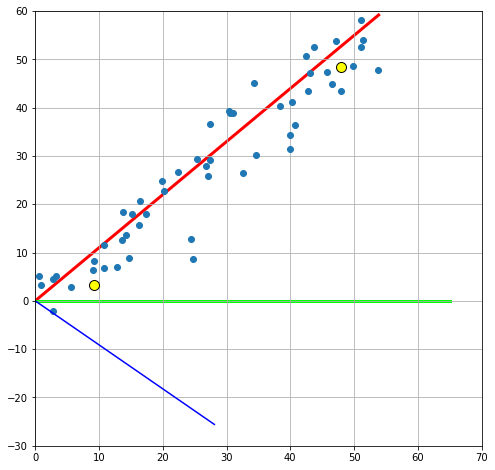

In [37]:
#Plot
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim(0, 70)
ax.set_ylim(-30, 60)
ax.scatter(example[:,0], example[:,1], zorder=2)
ax.plot([0, -80*pca.components_[0][0]], [0, -80*pca.components_[0][1]], c='r', lw = 3, zorder=1)
ax.plot([0, 65], [0, 0], c='lime', lw = 3, zorder=1)
ax.plot([0, 38*pca.components_[1][0]], [0, 38*pca.components_[1][1]], c='b')
ax.scatter(example[5,0], example[5,1], c='yellow', edgecolors='black', zorder=5, s=100)
ax.scatter(example[47,0], example[47,1], c='yellow', edgecolors='black', zorder=5, s=100)
ax.grid()
plt.show()

When the points' coordinates are projected onto the red component, the distance between the two points is almost entirely preserved. Onto the green line, representing the x-axis, we lose all concept of vertical distance, and only preserve horizontal distance. Onto the blue line, we lose almost all notion of distance between the points.

The blue line does preserve some distances well, but the red line, along the direction of greatest variance, will preserve the most distances.

Variance is a measure of data 'spread' - to preserve variance is to preserve 'spread'. To preserve 'spread' is to preserve point-to-point distances. Preserving point-to-point distances, we preserve the 'structure' of the data.

    
>***Preserving Variance → Preserves Spread → Preserves Distances → Preserves Structure ***

##### How do we actually implement PCA?

1\. Center your data. Sometimes, libraries take care of this, sometimes not, so it's a good habit to always do it first yourself.
- See the 'CenteringPCA' notebook for an explanation of motivation.

2\. Compute the covariance matrix.
  
- In general, covariance between $X$ and $Y$ is computed as:<br>
<br>
$$ E\ \Big[ \big(X - E\ [X]\big)\big(Y-E\ [Y]\big)\Big] $$
<br>
- In practice, letting $n$ equal the number of of examples/records/rows,  we often implement this using the form for discrete random variables:<br>
<br>
$$ \sum_{i = 1}^{n}\frac{\left(X_i - \mu_X\right)\left(Y_i - \mu_Y\right)}{n},\ \textrm{Where }\mu_Z\textrm{ represents the mean/expected value of }Z$$.

- I suggest you use np.cov() or a similar pre-built function, to ensure speed and accuracy.
- Interesting perspective: when working with centered two-dimensional data, datapoints in the $I^{st}$ and $III^{rd}$ quadrants contribute postively to covariance, and datapoints in the $II^{nd}$ and $IV^{th}$ quadrants contribute negatively to covariance. Can you see why?
  
[//]: # (This is a markdown comment. I'm using to note that the spaces below are necessary bc of Jupyter's weird numbering system)

3\. Compute the eigenvectors of the covariance matrix.<br>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &#8226; &nbsp; To see why, see the 'Interpreting the Eigenvectors of the Covariance Matrix' notebook.<br>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &#8226; &nbsp; We'll do an in-depth example of this later on in this notebook.<br>

4\. For *n*-component PCA, called the '*n$^{th}$*-rank approximation', take the first *n* eigenvectors.<br>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &#8226; &nbsp; Choosing *n* can be complicated, but a good start is to plot the eigenvalues, and use the elbow method. We'll do this here later on.

##### Let's Try an Example:

In [154]:
# We'll use our 'noisy line' data from above:
# Let's look at some of the rows of data
example[np.random.choice(example.shape[0], 10, replace=False), :]

array([[ 53.70560085,  47.84007896],
       [ 45.68422874,  47.3060087 ],
       [  0.95540348,   3.37154728],
       [ 24.76509677,   8.71348738],
       [ 51.11091204,  58.10626807],
       [  3.29012234,   5.22848391],
       [ 24.48777381,  12.75616348],
       [ 13.81724903,  18.46972168],
       [  2.85978022,  -2.12704287],
       [ 30.44372135,  39.3903665 ]])

##### Center the Data

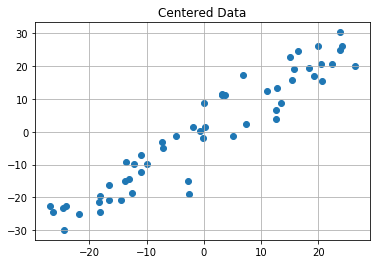

In [51]:
# Let's use sklearn's StandardScaler to center our data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std = False) # Scale mean, not variance

# Data will be centered at (0,0)
exampleScaled = scaler.fit_transform(example)
plt.scatter(exampleScaled[:,0], exampleScaled[:,1])
plt.grid()
plt.title("Centered Data")
plt.show()

##### Compute Covariance Matrix

In [54]:
# Compute Covariance Matrix
cv = np.cov(exampleScaled.T) # Have to transpose, due to the way np.cov() works
print("Covariance matrix:")
cv

Covariance matrix:


array([[ 250.85648648,  260.39040206],
       [ 260.39040206,  299.84142719]])

##### Find Eigenvectors

We first need to find the eigenvalues using $\ $$det\left(Cov(X) - \lambda I\right)$

$$Cov(X) = \begin{bmatrix} 250.856 & 260.390 \\260.390 & 299.841 \end{bmatrix}$$
<br>
$$Cov(X) - \lambda I = \begin{bmatrix} 250.856 - \lambda & 260.390 \\260.390 & 299.841 - \lambda \end{bmatrix}$$
<br>
$$det\left(Cov(X) - \lambda I\right) = \left(250.856 * 299.841\right) - 250.856\lambda - 299.841\lambda + \lambda^2 - (260.390^2)$$
<br>$$ = \lambda^2 -550.697\lambda + 7413.962$$

That last line is what we call the 'Characteristic Polynomial'. We set this equation to $0$, and solve for $\lambda$, the eigenvalues.

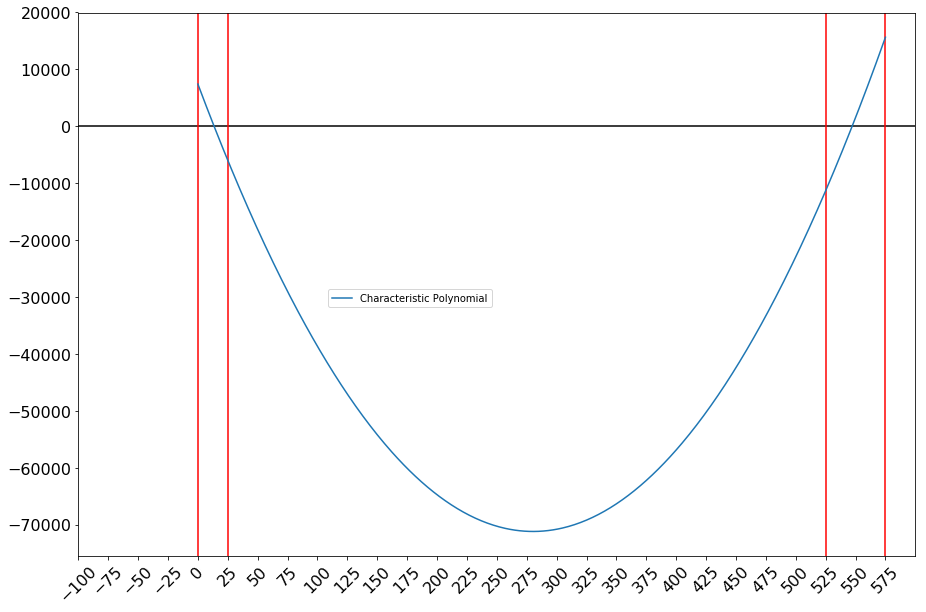

In [267]:
# We're gonna use some python to find the roots for us. There's a 'RootFinding' Notebook if you want to go more in depth.

# We're gonna use the brentq method, as that's what sklearn suggested when I google'd its root finding options.
# For each root, we require a function, and two x-values (a, b), where the signs of f(a) and f(b) are opposite.
# Note: there will be two (a,b) pairs, as the characteristic polynomial will have 2 roots, being quadratic

# Our function
def charPoly(x):
    return x**2 - 560.697*x + 7413.962
charPolyVectorize = np.vectorize(charPoly)

# To figure out our values of a & b, let's plot the function
indices = np.arange(576)
fVals = charPolyVectorize(indices)

# Plotting
fig, ax = plt.subplots(figsize = (15,10))
ax.tick_params(labelsize=16)
ax.set_xticks(np.arange(-100, 600, 25))
ax.set_yticks(np.arange(-90000, 20001, 10000))
ax.set_xlim(-100, 600)
plt.xticks(rotation=45)
plt.axhline(c='black')
plt.axvline(x=25, c='red')
plt.axvline(x=0, c='red')
plt.axvline(x=525, c='red')
plt.axvline(x=575, c='red')
plt.plot(indices, fVals, label = 'Characteristic Polynomial')
ax.legend(bbox_to_anchor=(0.5, 0.5))
plt.show()

The blue line is the characteristic polynomial, and the red lines are manually added in to see what might be good values for (a,b) pairs.

Looks like (0,25) and (525, 575) make good choices for our pairs.

In [139]:
from scipy.optimize import brentq

print("First Eigenvalue: " + str(brentq(charPoly, 525, 575)),
      "\nSecond Eigenvalue: " + str(brentq(charPoly, 0, 25)))

# Note: Eigenvalues are taken to be sorted in descending order.
# Thus, the 'first' eigenvalue is the eigenvalue with the greatest value. 

First Eigenvalue: 547.1467748299733 
Second Eigenvalue: 13.550225170026735


$\lambda_1 = 547.1467748299733$<br>
$\lambda_2 = 13.550225170026735$

##### Use eigenvalues to find eigenvectors - our principal components

The size/magnitude of the eigenvalue is directly related to how 'explanatory' or 'informative' its respective eigenvector is. So, we can see here that the first eigenvalue is much, much more explanatory than the second eigenvector - we can represent this data in one-dimension whilst still retaining the vast majority of information contained within the data.

To find the eigenvectors, we remember that an eigenvector is a vector that when multiplied into a matrix, only has its magnitude scaled (it's scaled precisely by it's associated eigenvalue). It will not be rotated in any way. We can use this fact to find our eigenvectors:

As I expect to present our matrix of principal components in the form where each row represents an eigenvector, and the columns represent a particular eigenvector's coordinates, I will use notation where $e_{ij}$ refers to the $j^{th}$ coordinate of the $i^{th}$ eigenvector.

Remember; eigenvectors are still represented\ in terms of their (x,y) coordinates here. It's only once we project our data onto these eigenvectors that we can turn our datapoints' (x,y) coordinates into (z) coordinates, where z represents coordinates along the eigenvector. In this particular example, where we start off with two columns of data, we're hoping the first eigvenvector alone is good enough to represnt the information within our original data.

For the first eigenvalue, corresponding to $\lambda_1$:
$$\begin{bmatrix} 250.856 & 260.390 \\ 260.390 & 299.841 \end{bmatrix} \cdot \begin{bmatrix} e_{11} \\ e_{12} \end{bmatrix}
 =\ \lambda_1\begin{bmatrix} e_{11}\\ e_{12}\end{bmatrix}$$

This is a simple linear system of equations:
$$250.856\cdot e_{11} + 260.390\cdot e_{12} = \lambda_1 \cdot e_{11}$$
$$260.390\cdot e_{11} + 299.841\cdot e_{12} = \lambda_1 \cdot e_{12}$$

Again, we will use python to solve this for us, for both eigenvalues:

In [155]:
coeff = np.array([[250.856, 260.390], [260.390, 299.841]])
la, v = np.linalg.eig(coeff)
print("Eigenvalues: ", la[::-1], "\n\nEigenvectors: \n", '\n', v[:,::-1]) 
# We use ::-1 to reverse printed order, keeping with descending-order convention

Eigenvalues:  [ 536.88785585   13.80914415] 

Eigenvectors: 
 
 [[-0.67318368 -0.73947531]
 [-0.73947531  0.67318368]]


Here, each column is a separate eigenvector. 

Notice, these are almost exactly the same results we got when we ran sklearn's PCA above [here](#PCA).

Also note that these vectors are already unit-length, but you might need to scale them to unit-length yourself when doing this with other libraries / by hand. 

To scale to unit length, simply divide each coordinate by the length of the eigenvector. 

The length of the eigenvector is the square_root(sum(squared_coordinate_values))

For example:
$$\begin{bmatrix} 7 & 5 \end{bmatrix} \rightarrow \begin{bmatrix} \frac{7}{\sqrt{7^2 + 5^2}} & \frac{5}{\sqrt{7^2 + 5^2}} \end{bmatrix} \rightarrow \begin{bmatrix} \frac{7}{\sqrt{74}} & \frac{5}{\sqrt{74}} \end{bmatrix}$$

In [156]:
np.sqrt(np.sum(v[0][0]**2 + v[0][1]**2))

1.0

##### Almost there - Projecting onto new component 'axes'

So now, all we have left to do is represent our original data in terms of our new components/'axes'.

Remember, in this example, we're trying to represent our 2D data in 1D.

I.e. represent our (x,y) data by a single coordinate (z), where that one (z) coordinate tells us where along the first component the datapoint sits.

A little more formally, taking (u,v) to be the coordinates of the projection of a datapoint onto our principal component, (z) is the scalar by which we multiply the unit-length principal component to reach the point (u,v). 

We want to take 2D (x,y) data and represent it by (z), a projection onto the principal component


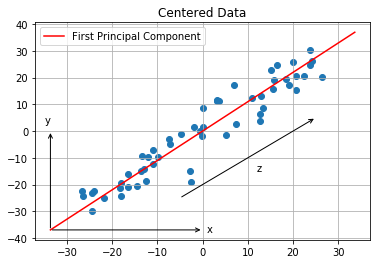

In [257]:

plt.scatter(exampleScaled[:,0], exampleScaled[:,1])
plt.grid()
plt.title("Centered Data")
plt.plot([-50*v[:,1][0], 50*v[:,1][0]], [-50*v[:,1][1], 50*v[:,1][1]], c='r', label='First Principal Component')
plt.legend(loc='best')
print("We want to take 2D (x,y) data and represent it by (z), a projection onto the principal component")

plt.annotate("", xy=(25, 5), xytext=(-5, -25),
    arrowprops=dict(arrowstyle="->"))
plt.text(12, -15, 'z')

plt.annotate("", xy=(50*v[:,1][0], 0), xytext=(50*v[:,1][0], 50*v[:,1][1]),
    arrowprops=dict(arrowstyle="->"))
plt.text(-35, 3, 'y')

plt.annotate("", xy=(0, 50*v[:,1][1]), xytext=(50*v[:,1][0], 50*v[:,1][1]),
    arrowprops=dict(arrowstyle="->"))
plt.text(1, -38, 'x')
plt.show()

The way we project onto the first component is a simple dot product:

I personally like to get my output in a matrix of the form examples x features, so to do so, the multiplication would be as such:
<br>
<br>
\begin{array}{ccc}
&\text{Scaled} &&& \text{Principal} &&& \text{New Features} \\
&\text{Features} &&& \text{Component} \\
& \begin{bmatrix}
    x_{11} & x_{12}\\
    x_{21} & x_{22}\\
    \vdots & \vdots\\
    x_{m1} & x_{m2}
\end{bmatrix} &&\bullet&
\begin{bmatrix}
    e_1 \\
    e_2 \\
\end{bmatrix}
&=&&
\begin{bmatrix}
    z_{1}\\
    z_{2}\\
    \vdots\\
    z_{m}
\end{bmatrix}
\end{array}

We can check our work by subtracting two vectors:

$\big($Sklearn's PCA Result$\big)$ - dot-product$\big($scaled example data, first principal component$\big)$

In [264]:
(res[:,0] - np.dot(exampleScaled, (v[:,1])))

array([ -2.62081933e-07,   3.32864744e-07,   1.69445581e-07,
         3.20030757e-07,  -9.05667434e-08,  -3.87569145e-07,
         3.94037400e-07,  -2.40113714e-07,  -4.17378018e-07,
        -4.31426066e-07,  -1.17707451e-07,   5.89642845e-07,
         3.27801359e-08,   4.77863253e-07,  -1.37143630e-09,
         4.18503593e-07,   5.81144022e-09,  -1.40497739e-06,
        -5.42019762e-09,   9.71130483e-08,   4.38975027e-07,
         3.05454916e-07,  -1.02919804e-06,   3.60898730e-07,
         2.46233890e-07,   1.09301236e-07,   7.58373498e-07,
         3.15670459e-07,  -6.13023234e-07,   6.56238590e-08,
        -1.51933210e-07,   6.19200893e-07,  -8.72753104e-07,
        -4.82901187e-07,   6.53152709e-07,   7.07523274e-07,
        -6.30244504e-07,   8.39556215e-07,   3.53817740e-08,
        -7.34703818e-08,  -3.49759212e-07,  -5.27843712e-07,
        -5.53635395e-08,  -1.17667881e-07,  -6.18707769e-07,
         5.42489790e-07,   1.64531606e-07,  -1.65861124e-07,
         5.75445952e-07,

Hurray! We have essentially the same result as the sklearn library. The small differences are probably due to roundoff error at some point. 